In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime
import scipy.signal as signal
import scipy.stats as stats
import scipy.interpolate as interpolate
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.lines as mlines
import seaborn as sbs
# plt.style.use("/mnt/e/Cohen_Lab/Data/report.mplstyle")
plt.style.use("/mnt/c/Users/billj/report.mplstyle")
# plt.style.use("../../report.mplstyle")

In [2]:
fs=10.2
start_hpf = 20
expt_info = pd.read_csv("experiment_data.csv")
start_times = [datetime.strptime(t,"%H:%M:%S") for t in list(expt_info["start_time"])]
offsets = [s - start_times[0] for s in start_times]
offsets = [o.seconds for o in offsets]
expt_info["offset"] = offsets
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600
expt_info = expt_info.sort_values("offset").reset_index()

### Plot masks

0 225.72080088987764 36.688542825361516
1 260.80546075085323 254.95221843003412
2 516.5994832041343 255.2170542635659
3 864.2395833333334 257.2083333333333
4 549.9381188118812 393.31435643564356
5 846.2 416.9172413793103
6 237.0835380835381 597.2960687960688
7 832.5098684210526 600.5986842105264
8 528.0393374741201 771.5486542443064
9 821.0137931034483 786.2827586206896
10 211.19378427787933 955.5575868372944
11 509.5395948434622 969.0349907918969
12 834.5635838150289 893.4942196531792


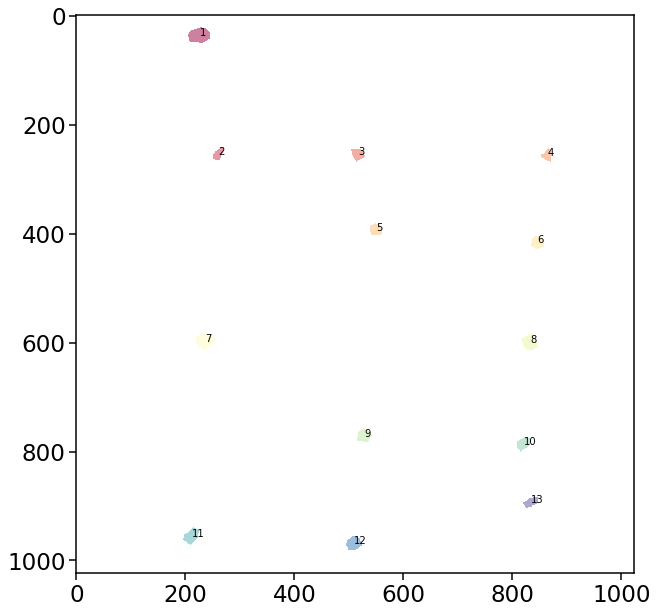

In [109]:
from skimage.io import imread, imsave
from skimage.measure import regionprops
# img = imread("labelling_pictures/AVG_cochr_E3_3ms_30mspulse.tif")
mask = imread("ROIs.tif")
props = regionprops(mask)
mask = np.ma.masked_where(mask==0, mask)
fig1, ax1 = plt.subplots(figsize=(10, 12))
# ax1.imshow(img, cmap="gray")
ax1.imshow(mask, interpolation='none', alpha=0.5)
for idx, obj in enumerate(props):
    centroid = obj.centroid
    ax1.text(centroid[1], centroid[0], str(idx+1))
    print(idx, centroid[1], centroid[0])

In [3]:
def intensity_to_dff(intensity, window=401):
    kernel = np.ones(window)/window
    intensity_padded = np.concatenate([np.flip(intensity[:window//2]), intensity, np.flip(intensity[-window//2+1:])])
    ma = signal.convolve(intensity_padded, kernel, mode='valid')
    dFF = (intensity - ma)/ma
    return dFF

def prefilter_intensity(raw_intensity):
    b, a = signal.butter(5, 0.5)
    intensity = signal.filtfilt(b, a, raw_intensity)
    return intensity

def get_mean_signal_pd(data, rois, interval=(0,0), window = 401):
    start = interval[0]
    stop = interval[1]
    if stop == 0:
        stop = len(np.unique(data["t"]))
    dFF_mean = np.zeros(stop-start)
    dFFs = []
    for i, roi in enumerate(rois):
        intensity = prefilter_intensity(data.loc[roi]["mean_intensity"][start:stop])
        dFF = intensity_to_dff(intensity, window=window)
        dFF_mean = (dFF_mean*i + dFF)/(i+1)
        dFFs.append(dFF)
    return dFF_mean, dFFs

def get_mean_signal(data, rois, interval=(0,0), window = 401, background = None):
    start = interval[0]
    stop = interval[1]
    if stop == 0:
        stop = data.shape[1]
#     print(stop-start)

    dFF_mean = np.zeros(stop-start)
    dFFs = []
    for i, roi in enumerate(rois):
        intensity = prefilter_intensity(data[roi,start:stop])
        if background is not None:
            bi = prefilter_intensity(background[roi,start:stop])
            if np.mean(bi) < 0.8*np.mean(intensity):
                intensity = intensity - 0.8*bi
        dFF = intensity_to_dff(intensity, window=window)
        dFF_mean = (dFF_mean*i + dFF)/(i+1)
        dFFs.append(dFF)
    dFFs = np.array(dFFs)
    return dFF_mean, dFFs

def load_traces(expt_info, interval=(0,0), per_trace_start=0, background_subtract=False, scale_lowest_mean=False):
    start = interval[0]
    stop = interval[1]
    if stop == 0:
        stop = expt_info.shape[0]
    timepoints = np.arange(start, stop)

    window=401
    hours = []
    t = []
    data_blocks = []
    dFF_blocks = []
    centroid_blocks = []
    baselines = []
    for idx in timepoints:
        exptname = expt_info["file_name"].loc[idx]
        offset = expt_info["offset"].loc[idx]
        data = pd.read_csv("%s_traces.csv" % exptname).set_index("z").loc[0].set_index("region")
        background = pd.read_csv("background_traces/%s_traces.csv" % exptname).set_index("z").loc[0].set_index("region")
        
        t_timepoint = np.arange(len(np.unique(data["t"])))/fs +offset
        t_timepoint = t_timepoint[per_trace_start:]
        data_timepoint = np.zeros((len(data.index.unique("region")), len(t_timepoint)))
        background_timepoint = np.zeros((len(data.index.unique("region")), len(t_timepoint)))
        centroid_timepoint = np.zeros((len(data.index.unique("region")), 2, len(t_timepoint)))
        for i, roi in enumerate(data.index.unique("region")):
            data_timepoint[i,:] = data.loc[roi]["mean_intensity"][per_trace_start:]
            background_timepoint[i,:] = background.loc[roi]["mean_intensity"][per_trace_start:]
            centroid_timepoint[i,0,:] = data.loc[roi]["com_y"][per_trace_start:]
            centroid_timepoint[i,1,:] = data.loc[roi]["com_x"][per_trace_start:]
        t.extend(list(t_timepoint))
        data_blocks.append(data_timepoint)
        baselines.append(np.mean(data_timepoint, axis=1))
        centroid_blocks.append(centroid_timepoint)
        


    if scale_lowest_mean:
        baselines = np.array(baselines)
        print(baselines.shape)
        scalings = (baselines/np.min(baselines, axis=0)).T
        print(scalings.shape)
        for idx in range(baselines.shape[0]):
            data_blocks[idx] = data_blocks[idx]/scalings[:,idx][:,np.newaxis]
    
    for idx in range(len(data_blocks)):
        if background_subtract:
            dFF_mean, dFFs = get_mean_signal(data_blocks[idx], np.arange(data_blocks[idx].shape[0]), interval=(0,0), window=window, background=background_timepoint)
        else:
            dFF_mean, dFFs = get_mean_signal(data_blocks[idx], np.arange(data_blocks[idx].shape[0]), interval=(0,0), window=window, background=None)
        dFF_blocks.append(dFFs)

    t = np.array(t)
    t_interp = np.arange(np.min(t), np.max(t), step=1/fs)
    missing_data = np.zeros_like(t_interp, dtype=int)
    for t_idx in range(len(missing_data)):
        nearest_dist = np.min(np.abs(t-t_interp[t_idx]))
        if nearest_dist > 1/fs:
            missing_data[t_idx] = 1
    data_blocks = np.concatenate(data_blocks, axis=1)
    dFF_blocks = np.concatenate(dFF_blocks, axis=1)
    centroid_blocks = np.concatenate(centroid_blocks, axis=2)
    data_interp = np.zeros((data_blocks.shape[0], len(t_interp)))
    dFF_interp = np.zeros((dFF_blocks.shape[0], len(t_interp)))
    centroid_interp = np.zeros((centroid_blocks.shape[0], centroid_blocks.shape[1], len(t_interp)))
    plt.plot(t, dFF_blocks[10,:])

    for roi in range(data_interp.shape[0]):
#         print(len(t))
#         print(len(dFF_blocks[roi,:]))
        f_trace = interpolate.interp1d(t, data_blocks[roi,:])
        data_interp[roi,:] = f_trace(t_interp)
        f_dff = interpolate.interp1d(t, dFF_blocks[roi,:])
        dFF_interp[roi,:] = f_dff(t_interp)
        f_cy = interpolate.interp1d(t, centroid_blocks[roi,0,:])
        f_cx = interpolate.interp1d(t, centroid_blocks[roi,1,:])
        centroid_interp[roi,0,:] = f_cy(t_interp)
        centroid_interp[roi,1,:] = f_cx(t_interp)
    return t_interp, data_interp, dFF_interp, centroid_interp, missing_data

(36, 13)
(13, 36)


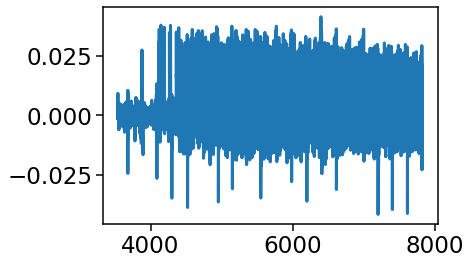

In [4]:
start = 12
stop = 48
t, raw, dff, centroid, missing = load_traces(expt_info, interval=(start,stop), per_trace_start=1, background_subtract=False, scale_lowest_mean=True)
hours = t/3600 + start_hpf

In [11]:
offsets = []
for i in np.arange(start, stop):
    offsets.append(expt_info["offset"].loc[i]/3600 + start_hpf)

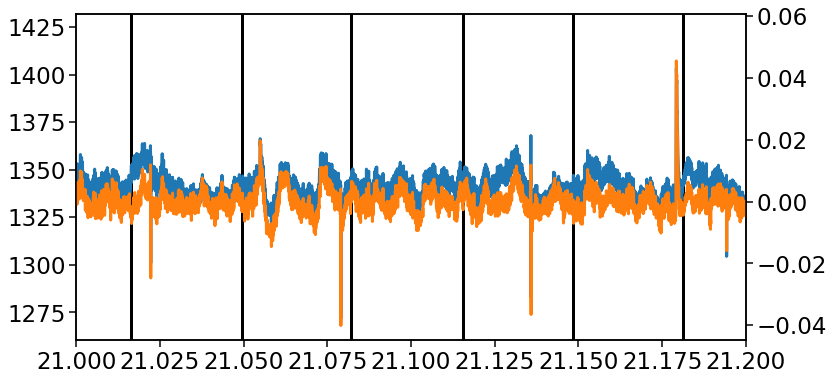

In [197]:
roi = 9
fig1, ax1 = plt.subplots(figsize=(12,6))
for o in offsets:
    ax1.axvline(o, color="black")
ax2 = ax1.twinx()
ax1.plot(hours, raw[roi,:])
ax1.set_xlim((21.0,21.2))
ax2.plot(hours, dff[roi,:], color="C1")

### Plot some nice DF/F or SNR traces

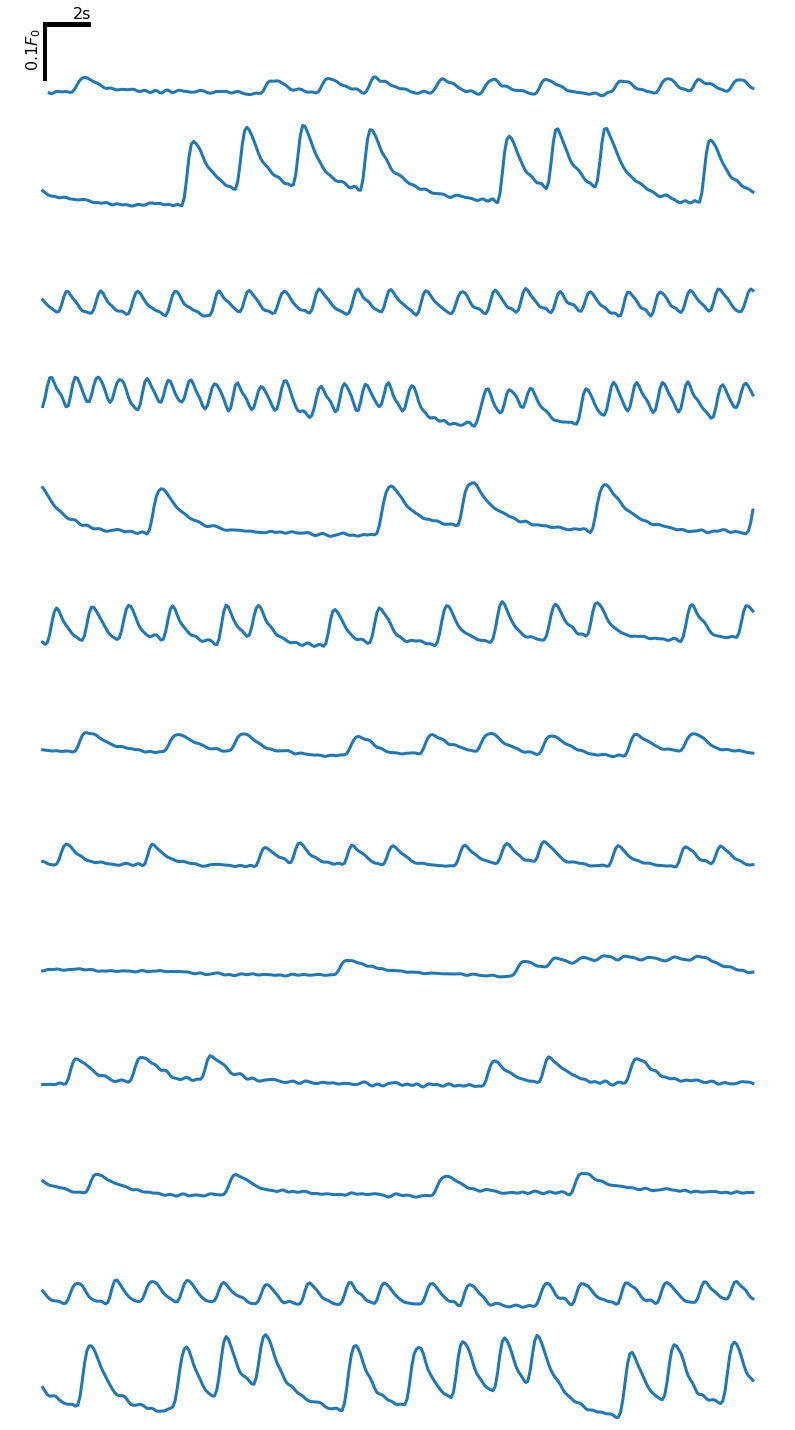

In [106]:
rois = np.arange(dff.shape[0])
fig1, axes = plt.subplots(len(rois), 1,figsize=(14,2*len(rois)))
axes = axes.ravel()
start_time = 30000
duration = 30
end_time = np.argwhere(t>(t[start_time]+duration))[0][0]
for roi in rois:
    trace = dff[roi,start_time:end_time]
    axes[roi].plot(t[start_time:end_time], trace-np.min(trace))
    axes[roi].set_ylim(-0.01, 0.16)
    axes[roi].set_axis_off()
r1 = Rectangle((6481, 0.13), 2, 0.007, color="black")
r2 = Rectangle((6481, 0.03), 0.15, 0.1, color="black")
axes[0].text(6482.3,0.142, "2s", size=16)
axes[0].text(6480.2,0.055, r"$0.1F_0$", size=16, rotation=90)
axes[0].add_patch(r1)
axes[0].add_patch(r2)
plt.savefig("../traces.tif")
plt.savefig("../traces.svg")


### Check correlation between DF/F and F on spikes

Here embryos that are observed to undergo the sharp transition

(-0.014483986907299734, 0.7244048631461566)
(0.12439822568032102, 0.0016850550929559862)
(0.06937758116613432, 0.05655821564667604)
(-0.01762598075964606, 0.6639468466455569)
(0.07599049397540875, 0.04537407927583739)


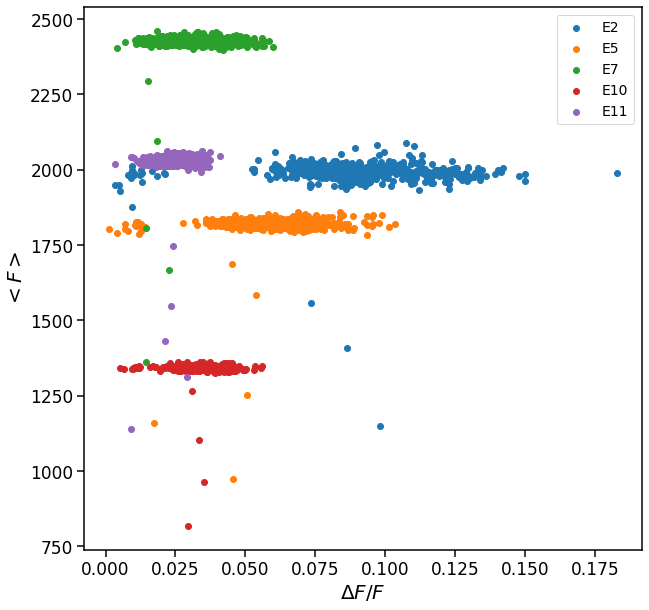

In [17]:
prominence = 0.015
fig1, ax1 = plt.subplots(figsize=(10,10))
for roi in [1,4,6,9,10]:
    peaks, properties = signal.find_peaks(dff[roi,:], prominence=prominence, wlen=400)
    peaks = peaks[dff[roi,peaks]>0]
    window = 400
    ma = np.convolve(raw[roi,:], np.ones(window)/window, 'same')
    ax1.scatter(dff[roi,peaks], ma[peaks], label="E%d" %(roi+1))
    print(stats.pearsonr(dff[roi,peaks],ma[peaks]))
ax1.set_xlabel(r"$\Delta F/F$")
ax1.set_ylabel(r"$<F>$")
ax1.legend()

(-0.11786756601014851, 0.003988183368389963)
-22.717942326494978
-52.72804296975229
(-0.14117031585405987, 0.0003593657747608446)
-24.499314229397637
-51.47843477523315
(-0.12054445319133927, 0.0008967705003584261)
-21.468688097494905
-67.96277647606233
(-0.12067089681051833, 0.002834362207327528)
-13.996229986337173
-11.772506219344786
(-0.13607708990885045, 0.000324302339251222)
-26.42556056576169
-24.046783592633126


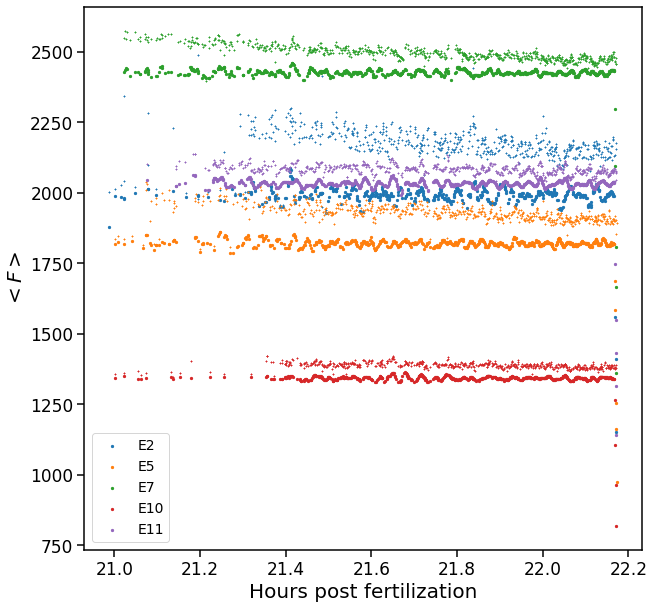

In [29]:
prominence = 0.015
fig1, ax1 = plt.subplots(figsize=(10,10))
for idx, roi in enumerate([1,4,6,9,10]):
    peaks, properties = signal.find_peaks(dff[roi,:], prominence=prominence, wlen=400)
    peaks = peaks[dff[roi,peaks]>0]
    window = 400
    ma = np.convolve(raw[roi,:], np.ones(window)/window, 'same')
    ax1.scatter(hours[peaks], ma[peaks], color="C%d" %idx, label="E%d" %(roi+1),s=5,linewidth=1)
    ax1.scatter(hours[peaks], raw[roi,peaks], color="C%d" %idx, marker="+", s=5, linewidth=1)
    print(stats.pearsonr(hours[peaks],ma[peaks]))
    print(stats.linregress(hours[peaks],ma[peaks]).slope)
    print(stats.linregress(hours[peaks],raw[roi,peaks]).slope)
ax1.set_xlabel(r"Hours post fertilization")
ax1.set_ylabel(r"$<F>$")
ax1.legend()

Embryos that already started beating and are changing frequency

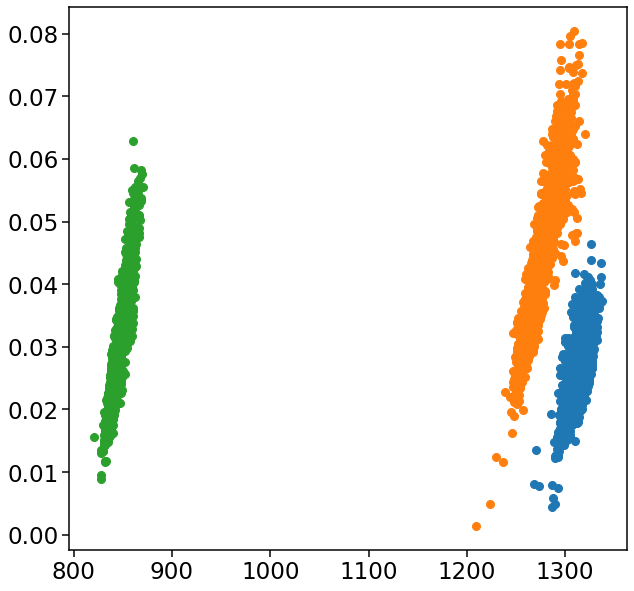

In [108]:
prominence = 0.015
fig1, ax1 = plt.subplots(figsize=(10,10))
for roi in [2,5,11]:
    peaks, properties = signal.find_peaks(dff[roi,:], prominence=prominence)
    peaks = peaks[dff[roi,peaks]>0]
    ax1.scatter(raw[roi,peaks], dff[roi,peaks])

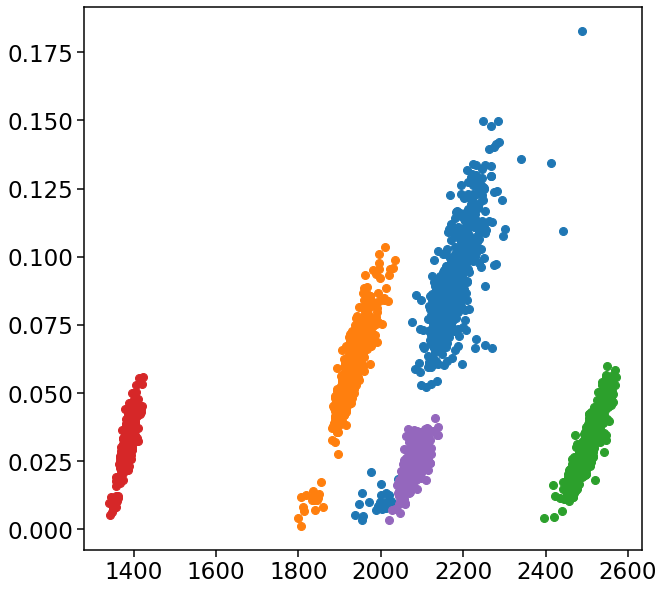

In [109]:
prominence = 0.015
fig1, ax1 = plt.subplots(figsize=(10,10))
for roi in [1,4,6,9,10]:
    peaks, properties = signal.find_peaks(dff[roi,:], prominence=prominence)
    peaks = peaks[dff[roi,peaks]>0]
    ax1.scatter(raw[roi,peaks], dff[roi,peaks])

ROI 4,6,9,10 has nice example of transition

### Detect peaks

Note here: we can do two different kinds of analysis. 1) Look at spikes that exceed a set threshold that we define as a heartbeat , and 2) Look at the "spikiest" spikes in each trace.

### Check frequency change over developmental time for selected embryos

In [17]:
spike_stats_by_roi = []
rois = [1,4,6,9,10]
start = 1
window = 401
for idx in range(65):
    exptname = expt_info["file_name"].loc[idx]
    data = pd.read_csv("%s_traces.csv" % exptname).set_index("z").loc[0].set_index("region")

    dFF_mean, dFFs = get_mean_signal_pd(data, np.unique(data.index), interval=(start,0), window=window)
    for roi in rois:
        dFF = dFFs[roi]
        prominence = 0.015
        peaks, properties = signal.find_peaks(dFF, prominence=prominence)
        peaks = peaks[dFF[peaks]>0]
        width_results = signal.peak_widths(dFF, peaks, rel_height=0.5)
        mean_prom = np.mean(properties["prominences"])
        mean_width = np.mean(width_results[0])/fs
        isi = (peaks[1:] - peaks[:-1])/fs
        mean_isi = np.mean(isi)
        std_isi = np.std(isi)
        mean_freq = len(peaks)/(len(dFF)/fs)
        spike_stats_by_roi.append((roi+1, expt_info["hpf"].loc[idx], mean_freq, mean_isi, std_isi, mean_prom, mean_width))

/home/billjia/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/billjia/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/billjia/.local/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/billjia/.local/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/billjia/.local/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
spike_stats_by_roi = pd.DataFrame(spike_stats_by_roi, columns=["embryo", "hpf", "mean_freq", "mean_isi", "std_isi", "mean_prom", "mean_width"])

Text(0, 0.5, 'Mean spike frequency (Hz)')

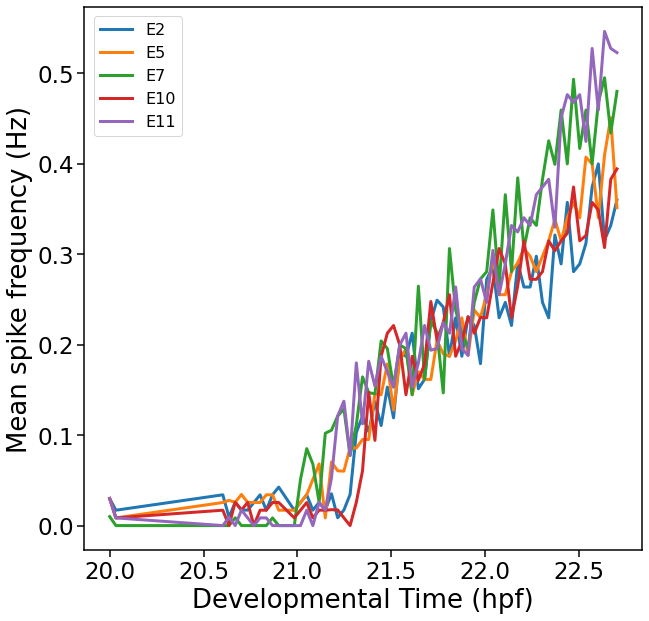

In [19]:
spike_stats_by_roi = spike_stats_by_roi.reset_index().set_index("embryo")
fig1, ax1 = plt.subplots(figsize=(10,10))
for embryo in spike_stats_by_roi.index.unique():
    e_data = spike_stats_by_roi.loc[embryo]
    ax1.plot(e_data["hpf"], e_data["mean_freq"], label= "E%d" % (embryo))
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")

Try with sliding window method

In [12]:
def find_segment_edges(missing_data):
    missing_edges = missing_data[1:] - missing_data[:-1]
    rising_edge = np.argwhere(missing_edges==1).ravel()
    falling_edge = np.argwhere(missing_edges==-1).ravel()
    segment_edges = list(zip([0] + list(falling_edge[:len(rising_edge)-1]), list(rising_edge)))
    return segment_edges

def generate_peak_detection_stats(dff, rois, window, prominence, overlap=0.5, missing_data=None):
    spike_stats_by_roi = []
    if missing_data is None:
        segment_edges = [(0, dff.shape[1])]
    else:
        segment_edges = find_segment_edges(missing_data)
    
    for roi in rois:
        e_data = dff[roi,:]
        peaks, properties = signal.find_peaks(e_data, prominence=prominence, wlen=400)
        peak_prominence = properties["prominences"][e_data[peaks]>0]
        peaks = peaks[e_data[peaks]>0]
        width_results = signal.peak_widths(e_data, peaks, rel_height=0.5)
    #     print(width_results)
        for i in np.arange(0, len(e_data), step=int(window - overlap*window)):
            if len(e_data) - i < window:
                break
            peak_indices = (peaks>=i)*(peaks<(i+window))
            window_peaks = peaks[peak_indices]
            mean_prom = np.mean(peak_prominence[peak_indices])
            
            mean_width = np.mean(width_results[0][peak_indices])/fs
            isi = []
            for edge_pair in segment_edges:
                segment_peaks = window_peaks[(window_peaks >= edge_pair[0])*(window_peaks <= edge_pair[1])]
                if len(segment_peaks) > 1:
    #                 hpf = t[i]/3600 + start_hpf
                    isi.extend(list((segment_peaks[1:] - segment_peaks[:-1])/fs))
            mean_isi = np.mean(isi)
            n_intervals = len(isi)
            if n_intervals > 5:
                std_isi = np.std(isi)
                std_width = np.std(width_results[0][peak_indices]/fs)
            else:
                std_isi = np.nan
                std_width = np.nan
            mean_freq = len(window_peaks)/((window - np.sum(missing[i:i+window]))/fs)
            spike_stats_by_roi.append((roi+1, t[i], mean_freq, mean_isi, std_isi, mean_prom, mean_width, std_width, n_intervals))

    spike_stats_by_roi = pd.DataFrame(spike_stats_by_roi, columns=["embryo", "offset", "mean_freq", "mean_isi", "std_isi", "mean_prom", "mean_width", "std_width", "n_intervals"])
    spike_stats_by_roi["hpf"] = spike_stats_by_roi["offset"]/3600 + start_hpf
    return spike_stats_by_roi


In [13]:
spike_stats_by_roi = []
rois = np.arange(dff.shape[0])
window = 1200
overlap = 0.9
prominence = 0.02
spike_stats_by_roi = generate_peak_detection_stats(dff, rois, window, prominence, overlap=overlap, missing_data=missing)


/home/billjia/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/billjia/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


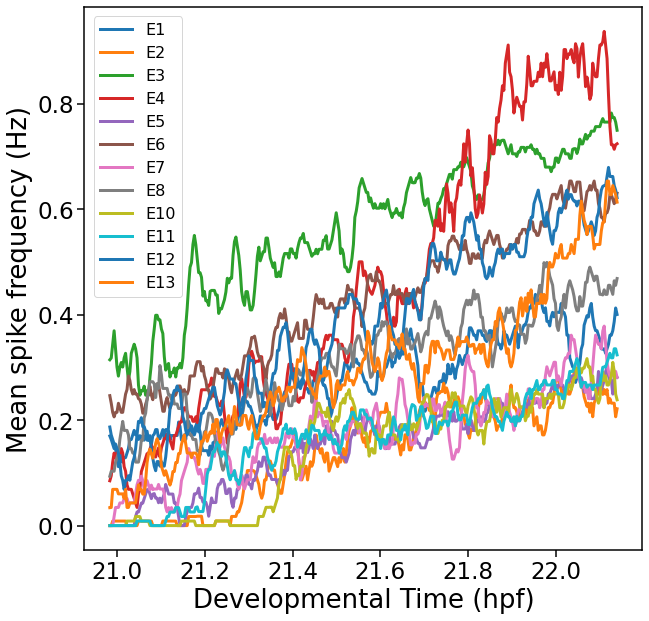

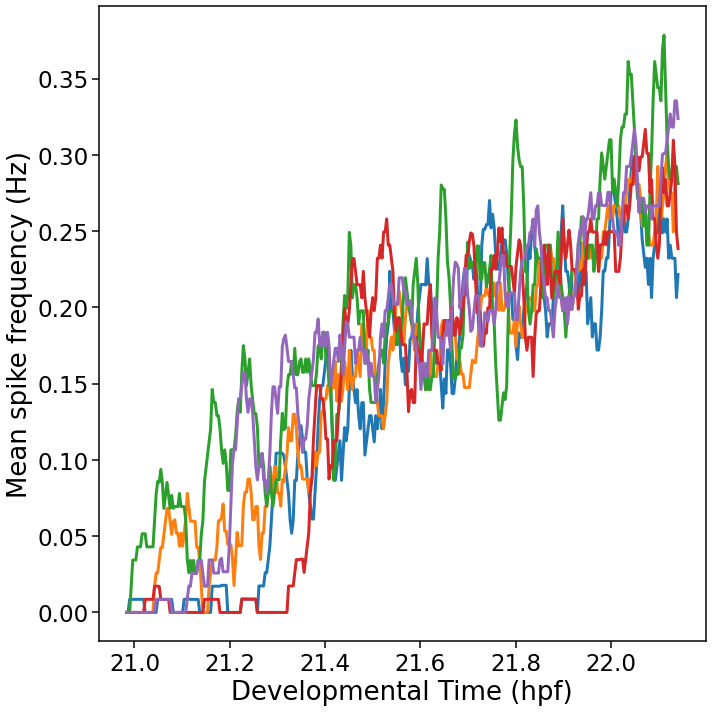

In [18]:
spike_stats_by_roi = spike_stats_by_roi.reset_index().set_index("embryo")
fig1, ax1 = plt.subplots(figsize=(10,10))
exclude_embryos = [9]
for embryo in spike_stats_by_roi.index.unique():
    if embryo not in exclude_embryos:
        e_data = spike_stats_by_roi.loc[embryo]
        ax1.plot(e_data["hpf"], e_data["mean_freq"], label= "E%d" % (embryo))
ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")

fig1, ax1 = plt.subplots(figsize=(10,10))
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
for embryo in embryos:
    if embryo not in exclude_embryos:
        e_data = spike_stats_by_roi.loc[embryo]
        ax1.plot(e_data["hpf"], e_data["mean_freq"], label= "E%d" % (embryo))
# ax1.legend()
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel("Mean spike frequency (Hz)")
plt.tight_layout()
plt.savefig("../mean_freq.svg")
plt.savefig("../mean_freq.tif")

In [192]:
spike_stats_by_roi = []
rois = np.arange(dff.shape[0])
window = 6120
overlap = 0.9
prominence = 0.022
spike_stats_by_roi = generate_peak_detection_stats(dff, rois, window, prominence, overlap=overlap, missing_data=missing)
spike_stats_by_roi = spike_stats_by_roi.reset_index().set_index("embryo")

/home/billjia/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/billjia/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


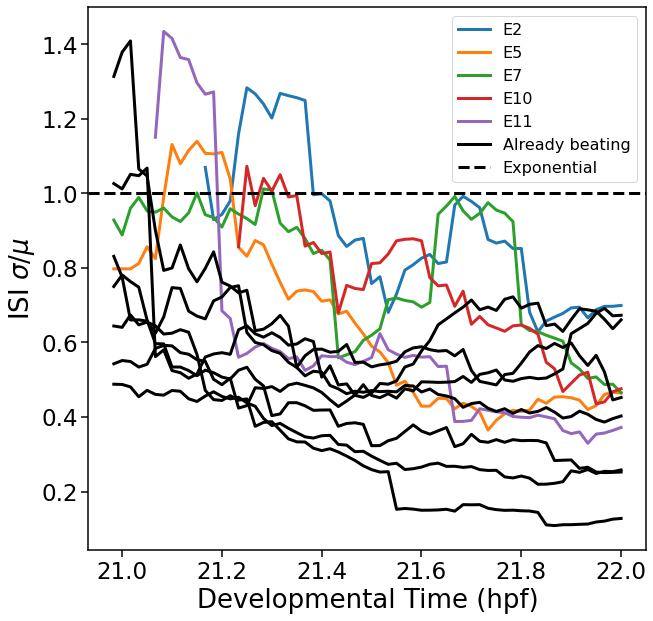

In [193]:
fig1, ax1 = plt.subplots(figsize=(10,10))
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
lines = []
for embryo in embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    l = ax1.plot(e_data["hpf"], e_data["std_isi"]/e_data["mean_isi"], label= "E%d" % (embryo))
    lines.extend(l)
beating_embryos = [1,3,4,6,8,12,13]
for embryo in beating_embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    ax1.plot(e_data["hpf"], e_data["std_isi"]/e_data["mean_isi"], color="black")
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"ISI $\sigma/\mu$")
l = mlines.Line2D([0], [0], color='black', label="Already beating")
lines.append(l)
l = ax1.axhline(1.0, color="black", label="Exponential", ls='--')
lines.append(l)
ax1.legend(handles=lines)

In [194]:
spike_stats_by_roi.loc[9]

,index,offset,mean_freq,mean_isi,std_isi,mean_prom,mean_width,std_width,n_intervals,hpf
embryo,,,,,,,,,,
9,496,3540.098039,0.000000,NaN,NaN,NaN,NaN,NaN,0,20.983361
9,497,3600.098039,0.000000,NaN,NaN,NaN,NaN,NaN,0,21.000027
9,498,3660.098039,0.000000,NaN,NaN,NaN,NaN,NaN,0,21.016694
9,499,3720.098039,0.000000,NaN,NaN,NaN,NaN,NaN,0,21.033361
9,500,3780.098039,0.001694,NaN,NaN,0.044133,92.106012,NaN,0,21.050027
...,...,...,...,...,...,...,...,...,...,...
9,553,6960.098039,0.081818,12.404295,7.710783,0.031444,4.788501,3.913095,42,21.933361
9,554,7020.098039,0.081736,12.399627,7.677530,0.030903,4.576560,3.255918,42,21.950027
9,555,7080.098039,0.081736,12.278245,7.552014,0.030431,5.065490,4.339373,42,21.966694


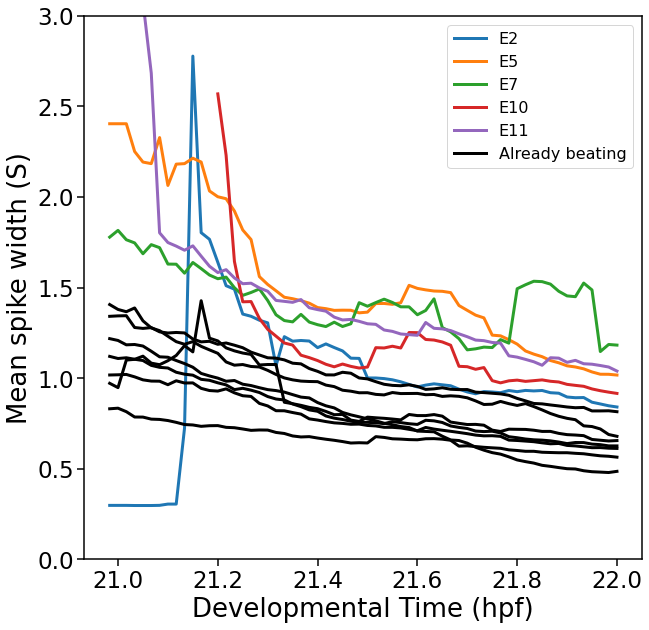

In [199]:
fig1, ax1 = plt.subplots(figsize=(10,10))
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
lines = []
for embryo in embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    l = ax1.plot(e_data["hpf"], e_data["mean_width"], label= "E%d" % (embryo))
    lines.extend(l)
beating_embryos = [1,3,4,6,8,12,13]
for embryo in beating_embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    ax1.plot(e_data["hpf"], e_data["mean_width"], color="black")
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"Mean spike width (S)")
l = mlines.Line2D([0], [0], color='black', label="Already beating")
ax1.set_ylim(0,3)
lines.append(l)
ax1.legend(handles=lines)

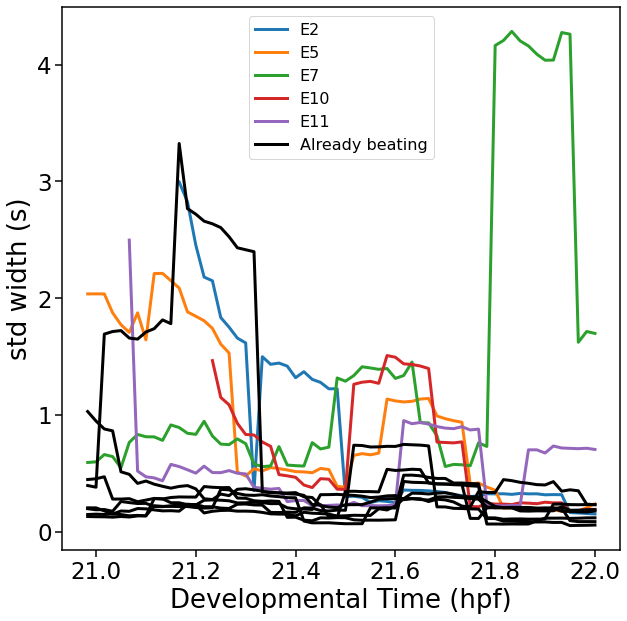

In [202]:
fig1, ax1 = plt.subplots(figsize=(10,10))
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
lines = []
for embryo in embryos:  
    e_data = spike_stats_by_roi.loc[embryo]
    l = ax1.plot(e_data["hpf"], e_data["std_width"], label= "E%d" % (embryo))
    lines.extend(l)
beating_embryos = [1,3,4,6,8,12,13]
for embryo in beating_embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    ax1.plot(e_data["hpf"], e_data["std_width"], color="black")
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"std width (s)")
l = mlines.Line2D([0], [0], color='black', label="Already beating")
# ax1.set_ylim(0,3)
lines.append(l)
ax1.legend(handles=lines)

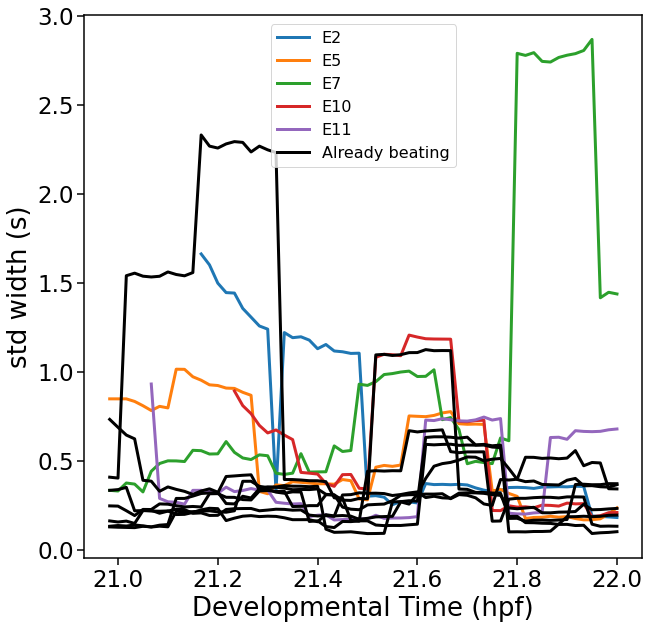

In [204]:
fig1, ax1 = plt.subplots(figsize=(10,10))
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
lines = []
for embryo in embryos:
    e_data = spike_stats_by_roi.loc[embryo]
    l = ax1.plot(e_data["hpf"], e_data["std_width"]/e_data["mean_width"], label= "E%d" % (embryo))
    lines.extend(l)
beating_embryos = [1,3,4,6,8,12,13]
for embryo in beating_embryos:     for i in np.arange(0, len(e_data), step=int(window - overlap*window)):
            if len(e_data) - i < window:
                break
            peak_indices = (peaks>=i)*(peaks<(i+window))
            window_peaks = peaks[peak_indices]
            widths = (peak_prominence[peak_indices])
            
            mean_width = np.mean(width_results[0][peak_indices])/fs
            isi = []
            for edge_pair in segment_edges:
                segment_peaks = window_peaks[(window_peaks >= edge_pair[0])*(window_peaks <= edge_pair[1])]
                if len(segment_peaks) > 1:
    #                 hpf = t[i]/3600 + start_hpf
                    isi.extend(list((segment_peaks[1:] - segment_peaks[:-1])/fs))
            mean_isi = np.mean(isi)
            n_intervals = len(isi)
            if n_intervals > 5:
                std_isi = np.std(isi)
                std_width = np.std(width_results[0][peak_indices]/fs)
            else:
                std_isi = np.nan
                std_width = np.nan
            mean_freq = len(window_peaks)/((window - np.sum(missing[i:i+window]))/fs)
            spike_stats_by_roi.append((roi+1, t[i], mean_freq, mean_isi, std_isi, mean_prom, mean_width, std_width, n_intervals))
    e_data = spike_stats_by_roi.loc[embryo]
    ax1.plot(e_data["hpf"], e_data["std_width"]/e_data["mean_width"], color="black")
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"std width (s)")
l = mlines.Line2D([0], [0], color='black', label="Already beating")
# ax1.set_ylim(0,3)
lines.append(l)
ax1.legend(handles=lines)

### See if there is correlation between spike width and interspike interval

In [5]:
def generate_all_peaks_stats(dff, rois, prominence, missing_data=None):
    spikes_by_roi = []
    
    for roi in rois:
        e_data = dff[roi,:]
        peaks, properties = signal.find_peaks(e_data, prominence=prominence, wlen=400)
        peak_prominence = properties["prominences"][e_data[peaks]>0]
        peaks = peaks[e_data[peaks]>0]
        if missing_data is not None:
            peaks = peaks[missing_data[peaks]==False]
            peak_prominence = peak_prominence[missing_data[peaks]==False]
        times = t[peaks]
        width_results = signal.peak_widths(e_data, peaks, rel_height=0.5)[0]/fs
        dat = np.concatenate([np.ones((len(times),1))*(roi+1), peaks[:,np.newaxis], times[:,np.newaxis], peak_prominence[:,np.newaxis], width_results[:,np.newaxis]], axis=1)
        dat = pd.DataFrame(dat, columns=["embryo", "peak_idx","offset_s", "prominence", "width"])
        isi = np.array([np.nan] + list(times[1:] - times[:-1]))
        dat["isi"] = isi
        spikes_by_roi.append(dat)
    spikes_by_roi = pd.concat(spikes_by_roi, axis=0)
    spikes_by_roi["hpf"] = spikes_by_roi["offset_s"]/3600 + start_hpf

    return spikes_by_roi

In [6]:
rois = np.arange(dff.shape[0])
spikes_by_roi = generate_all_peaks_stats(dff, rois, 0.02, missing_data=missing)
spikes_by_roi = spikes_by_roi.reset_index().set_index(["embryo"])

(3500.0, 4000.0)

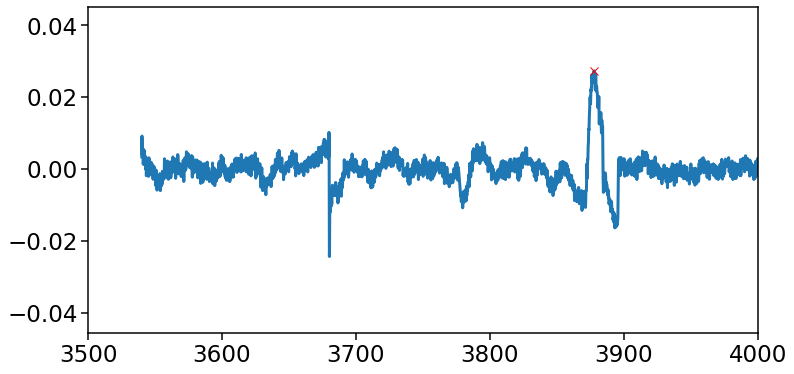

In [145]:
e = 11
edata = spikes_by_roi.loc[e]
peaks = np.array(edata["peak_idx"]).astype(int)
fig1, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(t, dff[e-1, :])
ax1.plot(t[peaks], dff[e-1,peaks], "rx")
ax1.set_xlim(3500,4000)

In [48]:
def autocorrelation(data, hpf, lag, window=31, overlap=0.5):
    ts = []
    lagn_corr = []
    for i in np.arange(0, len(data)-window, step=int(window - overlap*window)):
        windowed_data = data[i:i+window]
        lagged_data = data[i+lag:i+window+lag]
        corr, _ = stats.pearsonr(windowed_data, lagged_data)
        ts.append(i)
        lagn_corr.append(corr)
    ts = np.array(ts)
    lagn_corr = np.array(lagn_corr)
    return ts, lagn_corr

def autocorrelation(data, hpf, lag, window=31, overlap=0.5):
    ts = []
    lagn_corr = []
    for i in np.arange(0, len(data)-window, step=int(window - overlap*window)):
        windowed_data = data[i:i+window]
        lagged_data = data[i+lag:i+window+lag]
        corr, _ = stats.pearsonr(windowed_data, lagged_data)
        ts.append(i)
        lagn_corr.append(corr)
    ts = np.array(ts)
    lagn_corr = np.array(lagn_corr)
    return ts, lagn_corr

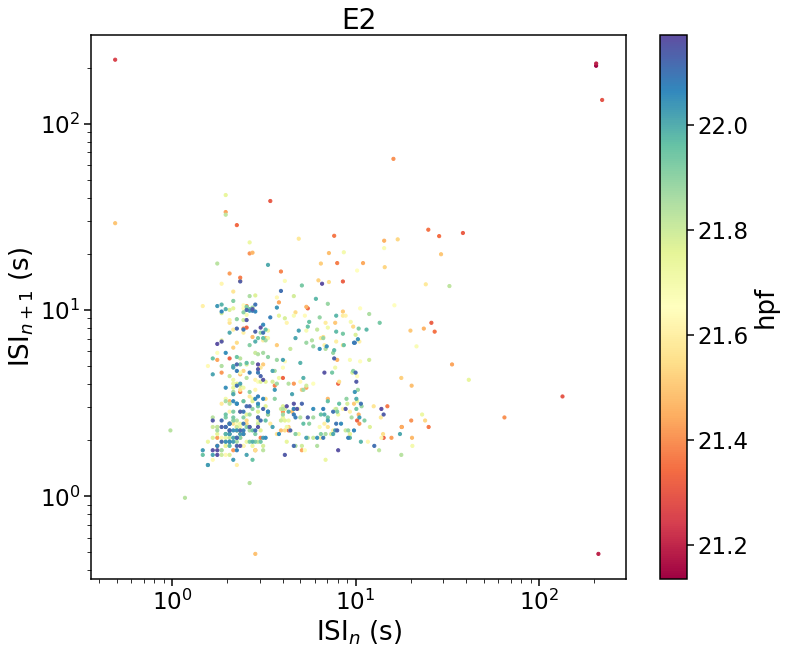

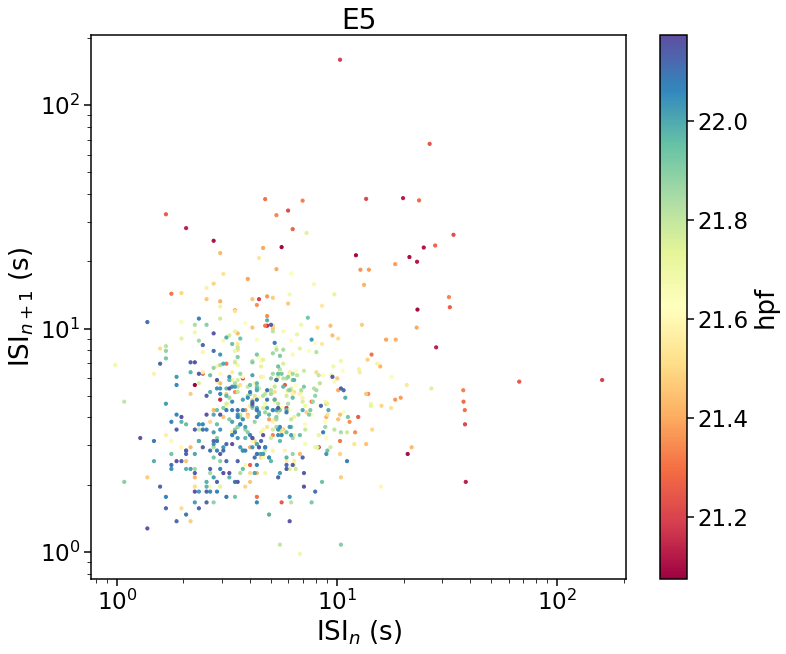

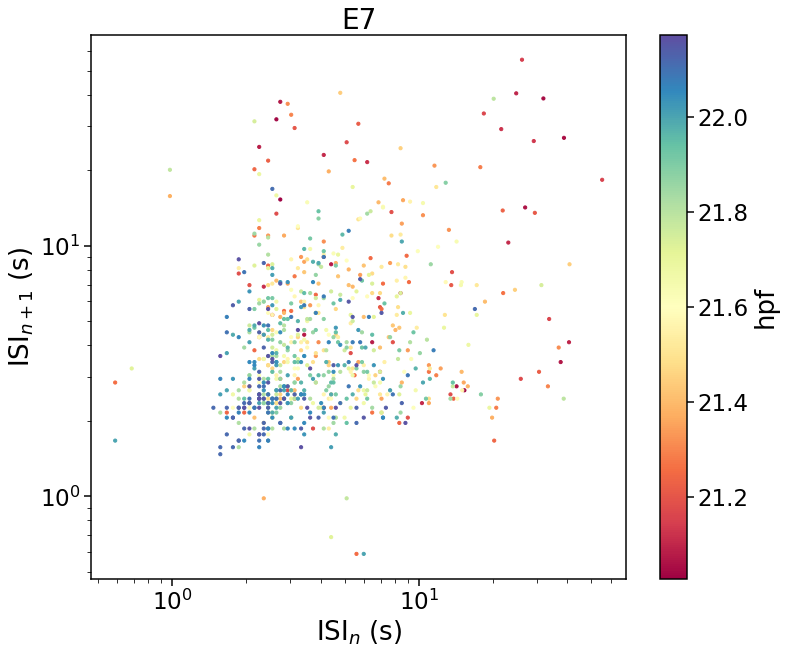

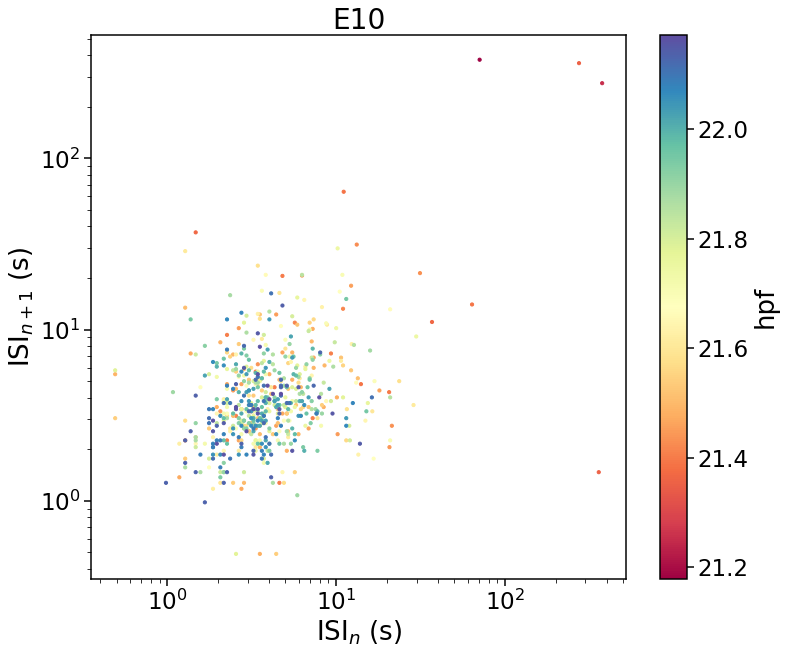

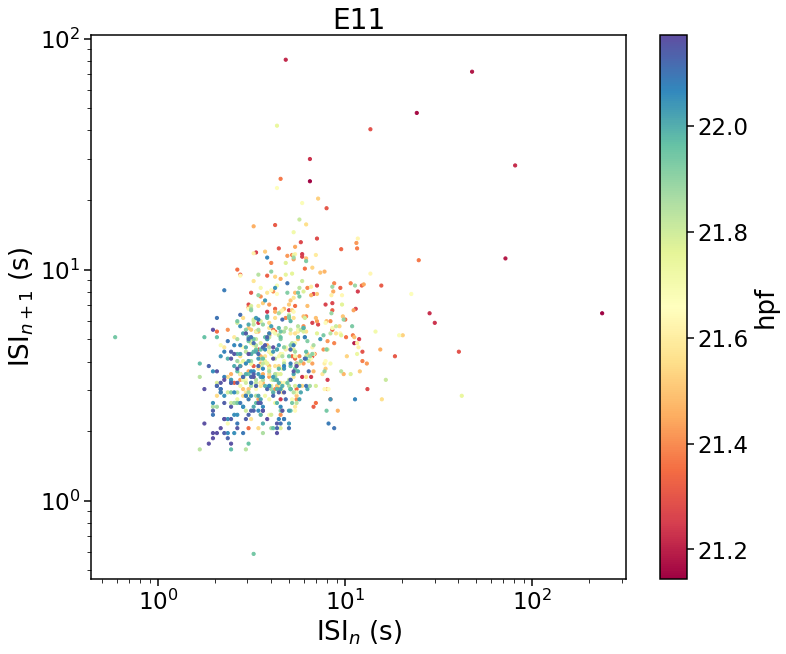

In [57]:
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
for e in embryos:
    fig1, ax1 = plt.subplots(figsize=(12,10))
    edata = spikes_by_roi.loc[e]
    isi = np.array(edata["isi"])[1:]
#     print(isi.shape)
    hpf = np.array(edata["hpf"])[1:]
    n1 = isi[:-1]
    n2 = isi[1:]
    hpf = hpf[1:]
    thresh = 0
    q = ax1.scatter(n1[hpf>thresh],n2[hpf>thresh], s=10, c=hpf[hpf>thresh])
    cbar = plt.colorbar(q)
    cbar.set_label("hpf")
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title("E%d" % e)
    ax1.set_xlim()
    ax1.set_ylabel(r"ISI$_{n+1}$ (s)")
    ax1.set_xlabel(r"ISI$_{n}$ (s)")
#     fig2, ax2 = plt.subplots(figsize=(12,6))
#     ts, l1_corr = autocorrelation(isi, 1, window=70, overlap=0.9)
#     ax2.scatter(hpf[ts], l1_corr)

(0.0, 3.0)

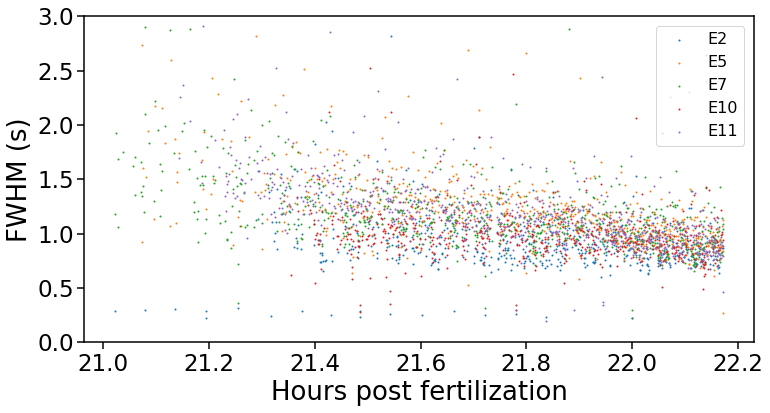

In [37]:
rois = [1,4,6,9,10]
embryos = [roi+1 for roi in rois]
fig1, ax1 = plt.subplots(figsize=(12,6))
for e in embryos:
    edata = spikes_by_roi.loc[e]
    
    ax1.scatter(edata["hpf"], edata["width"], s=1, label="E%d" % e)
ax1.set_xlabel("Hours post fertilization")
ax1.set_ylabel("FWHM (s)")
ax1.legend()
ax1.set_ylim((0,3))

Text(0, 0.5, 'ISI(s)')

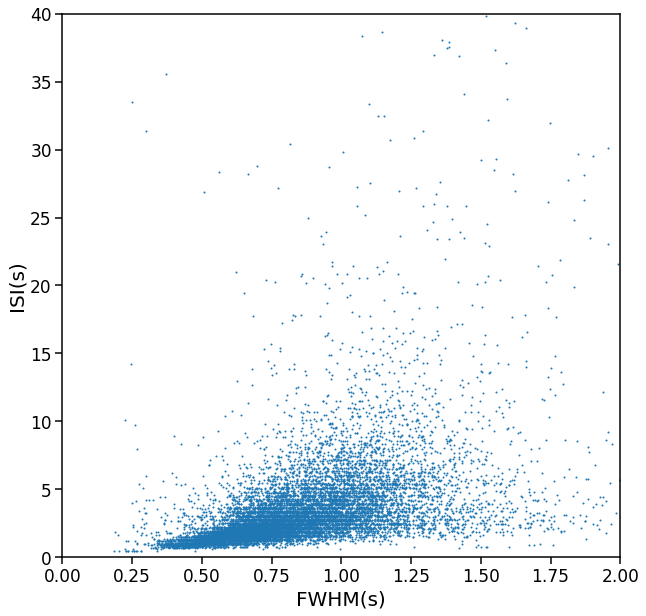

In [47]:
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.scatter(spikes_by_roi["width"], spikes_by_roi["isi"], s=1)
ax1.set_xlim(0,2)
ax1.set_ylim(0,40)
ax1.set_xlabel("FWHM(s)")
ax1.set_ylabel("ISI(s)")

### Look at centroids during peaks

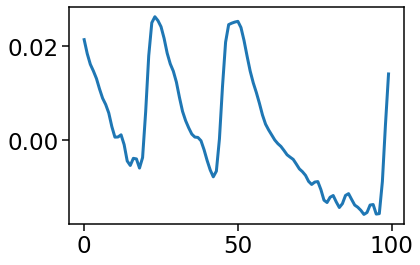

In [171]:
embryo = 11
edata = spikes_by_roi.loc[e]
peaks = np.array(edata["peak_idx"])
pidx = int(peaks[400])
duration = 50
plt.plot(dff[embryo-1,pidx-duration:pidx+duration])

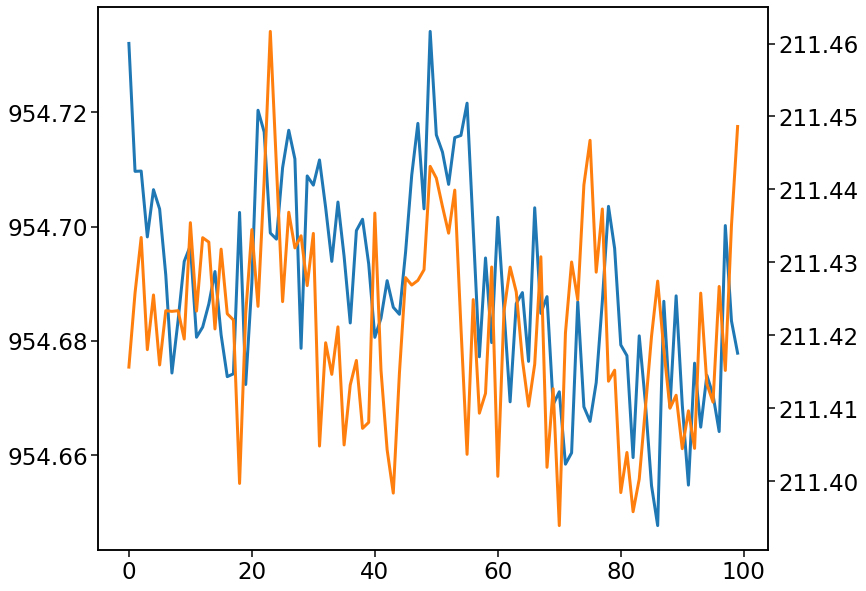

In [172]:
fig1, ax1 = plt.subplots(figsize=(12, 10))
ax2 = ax1.twinx()
ax1.plot(centroid[embryo-1,0,pidx-duration:pidx+duration])
ax2.plot(centroid[embryo-1,1,pidx-duration:pidx+duration], color="C1")

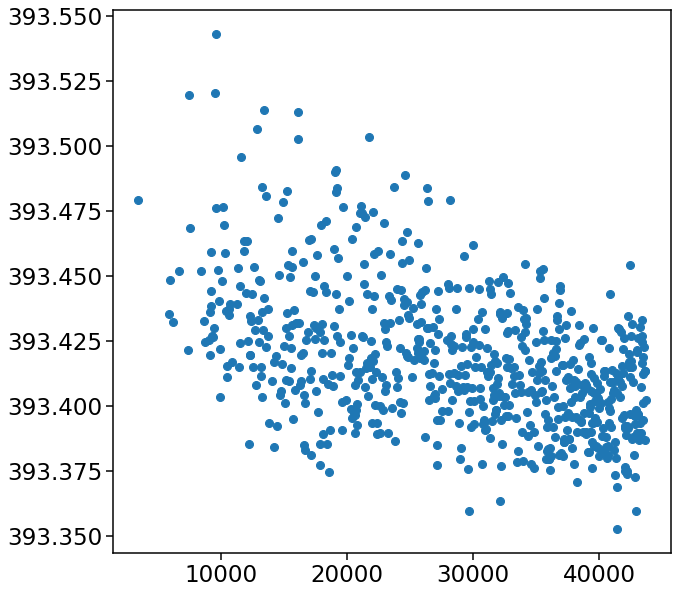

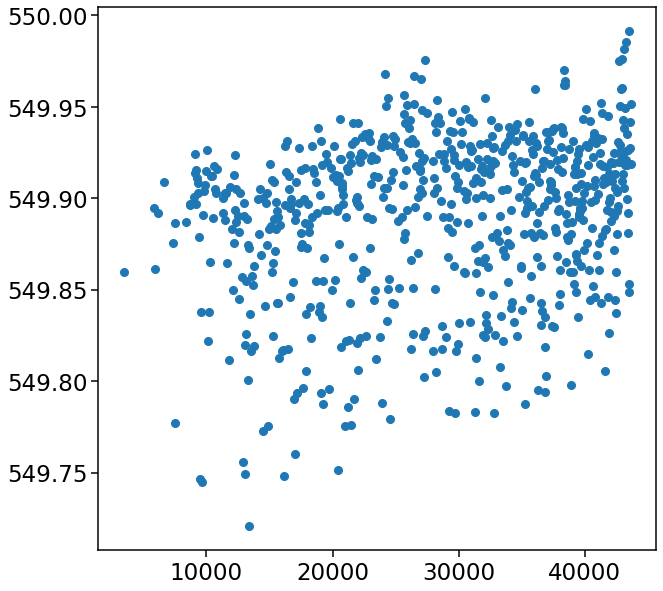

In [179]:
embryo = 5
edata = spikes_by_roi.loc[e]
peaks = np.array(edata["peak_idx"].astype(int))
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.scatter(peaks, centroid[embryo-1,0,peaks])
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.scatter(peaks, centroid[embryo-1,1,peaks])

### Look at peak magnitudes

Can we also look at skew to check whether amplitudes are growing? Maybe this will help estimate a baseline for spike detection as well?

In [34]:
def measure_baseline_noise(dff, rois, window, height, height_percentile=False, overlap=0.5, missing_data=None):
    dispersion = []
    for roi in rois:
        e_data = np.ma.masked_array(dff[roi,:], missing_data)
        for i in np.arange(0, len(e_data), step=int(window - overlap*window)):
            window_data = e_data[i:i+window]
            window_data = window_data[~window_data.mask]
            if height_percentile:
                threshold = np.percentile(window_data, height)
            else:
                threshold = height
            full_std = np.std(window_data)
            threshold_std = np.std(window_data[window_data<threshold])
            full_skew = stats.skew(window_data)
            threshold_skew = stats.skew(window_data[window_data<threshold])
            dispersion.append((roi+1, t[i], full_std, threshold_std, full_skew, threshold_skew))
    dispersion = pd.DataFrame(dispersion, columns=["embryo", "offset", "full_std", "threshold_std", "full_skew", "threshold_skew"])
    dispersion["hpf"] = dispersion["offset"]/3600 + start_hpf
    return dispersion


In [79]:
rois = [1,4,6,9,10]
window = 6120
overlap = 0.9
dispersion_df = measure_baseline_noise(dff, rois, window, height = 0.015, overlap=overlap, missing_data=missing)

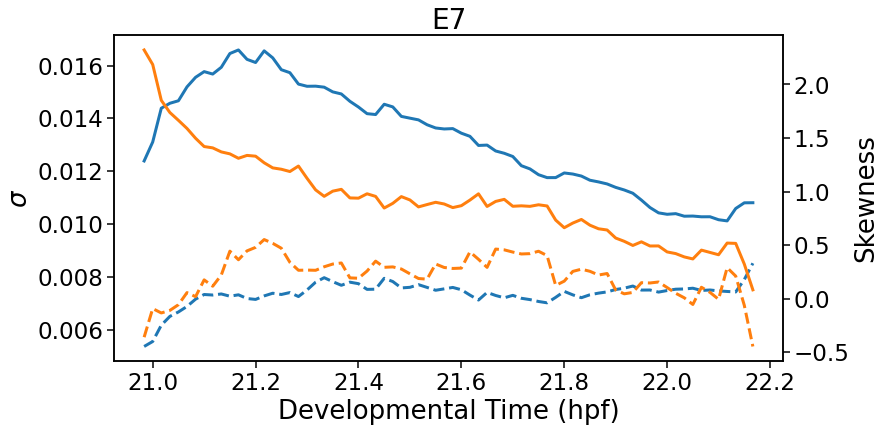

In [80]:
dispersion_df = dispersion_df.reset_index().set_index(["embryo"])
fig1, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
embryos = [r+1 for r in rois]
idx = 2
embryo_data = dispersion_df.loc[embryos[idx]]
ax1.set_title("E%d" % embryos[idx])
ax1.set_xlabel("Developmental Time (hpf)")
ax1.set_ylabel(r"$\sigma$")
ax2.set_ylabel("Skewness")
ax1.plot(embryo_data["hpf"], embryo_data["full_std"])
ax1.plot(embryo_data["hpf"], embryo_data["threshold_std"], "--",color="C0")
ax2.plot(embryo_data["hpf"], embryo_data["full_skew"], color="C1")
ax2.plot(embryo_data["hpf"], embryo_data["threshold_skew"], "--",color="C1")

This will tell us whether there are small peaks on top of large calcium elevations.

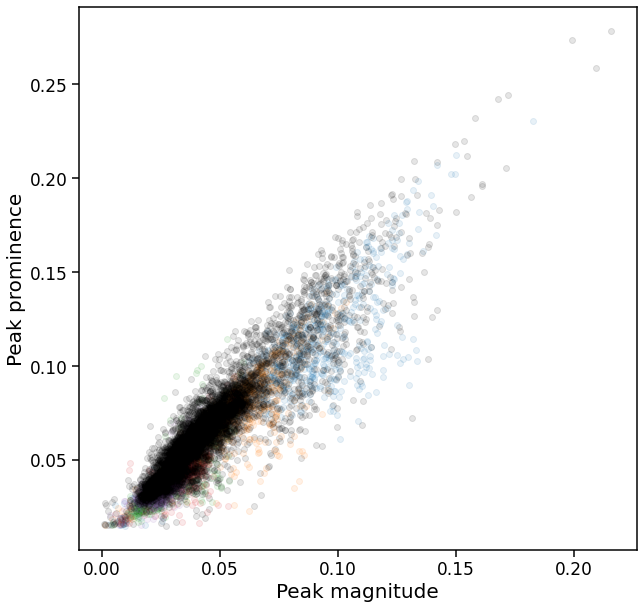

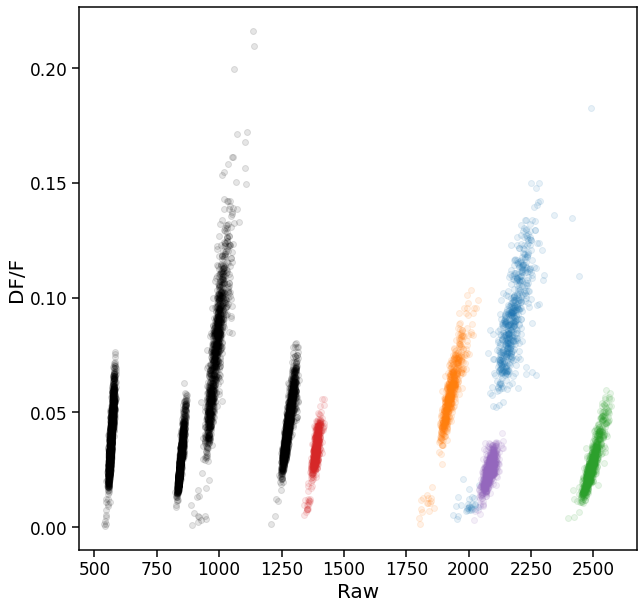

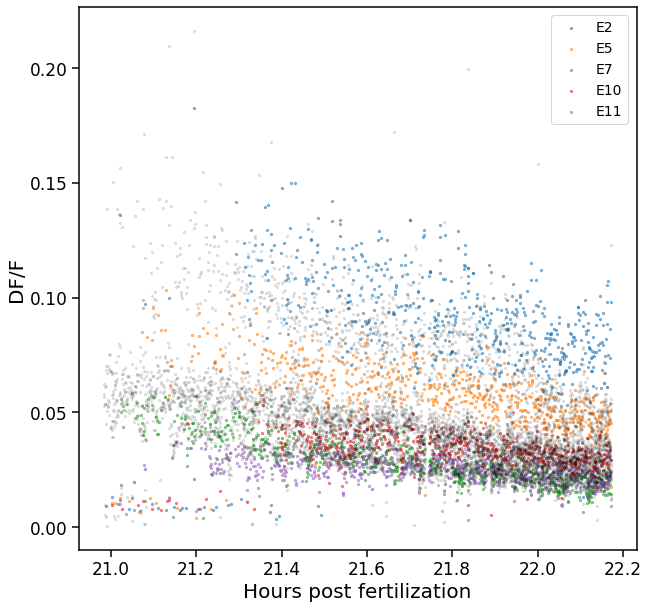

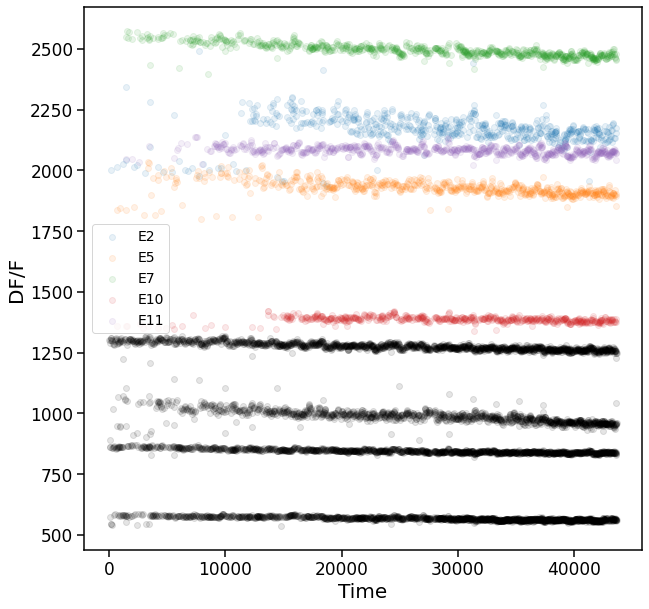

In [37]:
rois = [1,4,6,9,10]
window = 6120
overlap = 0.9
prominence = 0.015
segment_edges = find_segment_edges(missing)

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xlabel("Peak magnitude")
ax1.set_ylabel("Peak prominence")

fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.set_xlabel("Raw")
ax2.set_ylabel("DF/F")

fig3, ax3 = plt.subplots(figsize=(10,10))
ax3.set_xlabel("Hours post fertilization")
ax3.set_ylabel("DF/F")

fig4, ax4 = plt.subplots(figsize=(10,10))
ax4.set_xlabel("Time")
ax4.set_ylabel("DF/F")
# ax2.set_ylim((0,0.4))

# rois = np.arange(dff.shape[0])

for roi in rois:
    e_data = dff[roi,:]
    peaks, properties = signal.find_peaks(e_data, prominence=prominence)
    peak_prominence = properties["prominences"][e_data[peaks]>0]
    peaks = peaks[e_data[peaks]>0]
    ax1.scatter(e_data[peaks], peak_prominence, alpha = 0.1, label="E%d" % (roi+1))
    ax2.scatter(raw[roi,peaks], e_data[peaks], alpha=0.1, label="E%d" % (roi+1))
    ax3.scatter(hours[peaks], e_data[peaks], alpha=0.5, label="E%d" % (roi+1), s=5)
    ax4.scatter(peaks, raw[roi,peaks], alpha=0.1, label="E%d" % (roi+1))

ax3.legend()
ax4.legend()
    
beating_embryos = [4,6,12,13]
for embryo in beating_embryos:
    e_data = dff[embryo-1,:]
    peaks, properties = signal.find_peaks(e_data, prominence=prominence)
    peak_prominence = properties["prominences"][e_data[peaks]>0]
    peaks = peaks[e_data[peaks]>0]
    ax1.scatter(e_data[peaks], peak_prominence, alpha = 0.1, color="black")
    ax2.scatter(raw[embryo-1,peaks], e_data[peaks], alpha=0.1, color="black")
    ax3.scatter(hours[peaks], e_data[peaks], alpha=0.1, color="black",s=5)
    ax4.scatter(peaks, raw[embryo-1,peaks], alpha=0.1, color="black")

No, seems mostly 1 to 1. Also DF/F and raw fluorescence 

### Autocovariance heatmap

In [407]:
roi = 6
max_idx = 474
start_time = 12
end_time=36
timepoints = np.arange(start_time, end_time)
z_img = np.zeros((len(timepoints), max_idx))
pxx_img = np.zeros((len(timepoints), max_idx))
hours = []
lag = np.arange(max_idx)/fs
for idx in timepoints:
    exptname = expt_info["file_name"].loc[idx]
    hour = expt_info["hpf"].loc[idx]
    hours.append(hour)
    data = pd.read_csv("%s_traces.csv" % exptname).set_index("z").loc[0].set_index("region")
    
    dFF_mean, dFFs = get_mean_signal_pd(data, np.unique(data.index), interval=(start,0), window=window)

    dFF = dFFs[roi]
    dFF = (dFF - np.mean(dFF))
    z = signal.correlate(dFF, dFF, mode='same')
    f, pxx = signal.periodogram(dFF, fs=fs)
    z_img[idx-timepoints[0],:] = z[z.shape[0]//2:z.shape[0]//2+max_idx]
    pxx_img[idx-timepoints[0],:] = pxx[:max_idx]
    

In [408]:
e_data = spike_stats_by_roi.loc[roi+1].iloc[start_time:end_time]

In [ ]:
hours = np.array(hours)
fig1, ax1 = plt.subplots(figsize=(10,10))
width = z_img.shape[1]
lag_offset = 12
print(width)
im = ax1.imshow(z_img[:,lag_offset:], extent=(0, width-lag_offset, width, 0), vmax=np.max(z_img[:,lag_offset:].ravel()), vmin=-np.max(z_img[:,lag_offset:].ravel()))
cbar = ax1.figure.colorbar(im, aspect=20, shrink=0.7, label=r"$K_{xx}(\tau)$")
yticklabels = list(hours[np.linspace(0, len(timepoints), num=5, dtype=int, endpoint=False)])
yticklabels = ["%.1f" % t for t in yticklabels]
xticklabels = list(lag[np.linspace(lag_offset, len(lag), num=5, dtype=int, endpoint=False)])
xticklabels = ["%.2f" % t for t in xticklabels]
ax1.set_yticklabels(yticklabels)
ax1.set_xticklabels(xticklabels)
ax1.set_ylabel("Developmental Time (hpf)")
ax1.set_xlabel("Lag (s)")

ax1.set_xlim(0, width-lag_offset)
ax1.set_ylim(0,width)
ax1.invert_yaxis()
ax1.plot((1/e_data["mean_freq"] - lag[lag_offset])*(width-lag_offset)/(lag[-1]-lag[lag_offset]),(e_data["hpf"]-hours[0])*width/(hours[-1]-hours[0]), label= "Mean ISI(s)", color="black")
ax1.legend()
ax1.set_title("E%d" % (roi+1))
plt.tight_layout()

### Spectrogram

In [39]:
roi = 10
nperseg = 1200
overlap = 0.6
f, t_s, Sxx = signal.spectrogram(dff[roi,:]-np.mean(dff[roi,:]), fs=fs, nperseg=nperseg, noverlap=int(overlap*nperseg))

/home/billjia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


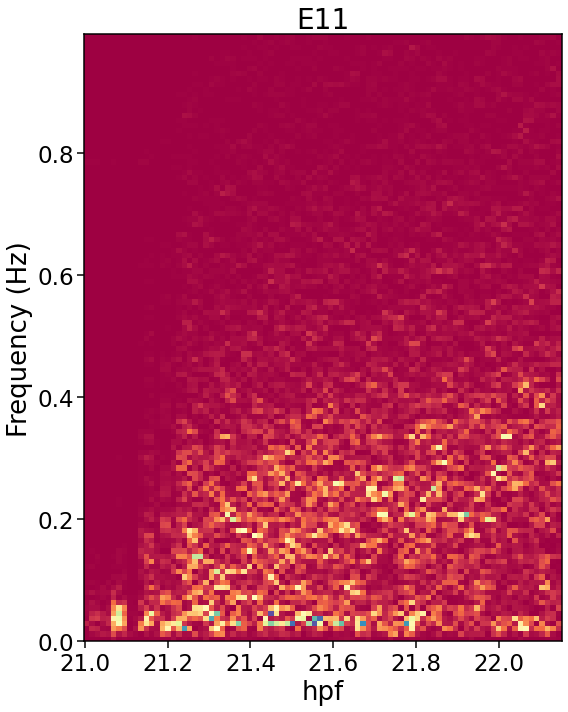

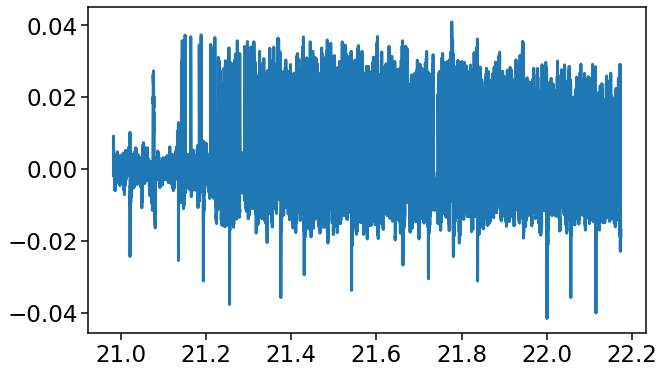

In [40]:
fig1, ax1 = plt.subplots(figsize=(8,10))
img = ax1.pcolormesh((t_s+np.min(t))/3600 + start_hpf, f[f<1], Sxx[f<1,:])
# cbar = ax1.figure.colorbar(img, aspect=20, shrink=0.7, label=r"$S_{xx}(f)$")
ax1.set_xlabel("hpf")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_title("E%d" %(roi+1))
plt.tight_layout()
plt.savefig("../E%d_spectrogram.tif" %(roi+1))
fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(t/3600 + start_hpf, dff[roi,:])